# Quantum-Classical Convolutional Neural Networks (QCCNN) for detecting hand-written digits

Explanation of the algorithm implemented in paper and our additional training of the quantum convolutional kernel ansatz.

0. Import the necessary packages and the QC_CNN class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from qat.lang.AQASM import Program, H, RX, RY, RZ, CNOT
from qat.qpus import get_default_qpu, PyLinalg
from qat.core import Observable, Term
from qat.plugins import ObservableSplitter
#from qlmaas.qpus import LinAlg # Comment when using myQLM

from myQML import QCCNN, Angle_Encoding


1. Load the MNIST dataset, selecting the number of training and test images, and then normalize the image pixels to values between 0 and 1.

In [ ]:
n_training_images = 200
n_test_images = 50

mnist_dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_training_images]
train_labels = train_labels[:n_training_images]
test_images = test_images[:n_test_images]
test_labels = test_labels[:n_test_images]

train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

2. Define the parameters used for the QCCNN training

In [3]:
n_qubits = 4        # Number of qubits in the quantum convolutional kernel
device = 'myqlm'    # 'myqlm' or qaptiva'
n_blocks = 3        # Number of blocks in the quantum convolutional kernel
n_shots = None      # Number of shots for the quantum circuit. If None, it will use the default number of shots defined in the QPU.
optimizer = 'adam'  # Optimizer for the classical model
loss = 'sparse_categorical_crossentropy'    # Loss function for the classical model
learning_rate = 0.01  # Learning rate for the optimizer
opt_model_path = 'C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/qccnn_models/'           # Path to save the optimized model, if needed
np_arrays_path = 'C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/quantum_images_qccnn/'  # Path to save the quantum images and parameters


3. Define a custom QCCNN class that inheritates from the QCCNN class defined in myQML. We have the possibility here of defining the quantum ansatz and the classical neural network

In [4]:
# Modify it if desired or use the Default_CCNN class from myQML

class Custom_QCCNN(QCCNN):
    def quantum_conv_kernel_circuit(self, x):
        '''
        This method implements a quantum convolutional kernel circuit for a custom QCCNN.
        It applies a series of rotation gates and CNOT gates to the qubits based on the input data x and parameters params.
        The circuit is designed to encode the input data into the quantum state of the qubits.

        Parameters:
        -----------
        x (np.ndarray): 
            Input data vector of length n_qubits that is used as input angles of the rotation gates applied to each qubit in the feature map.

        params (np.ndarray): 
            Parameters for the rotation gates in the quantum circuit, which are optimized during training.

        Returns:
        --------
        expected_z_values (np.ndarray):
            The expectation values of the Z observable for each qubit after applying the quantum circuit.
        '''

        angle_encoding = Angle_Encoding(self.n_qubits)
        qprogram, qubits = angle_encoding.get_quantum_program(x)
        
        for b in range(self.n_blocks):
            for i, qubit in enumerate(qubits):
                qprogram.apply(RZ(self.params[3 * (i + b * self.n_qubits)]), qubit)
                qprogram.apply(RX(self.params[3 * (i + b * self.n_qubits) + 1]), qubit)
                qprogram.apply(RZ(self.params[3 * (i + b * self.n_qubits) + 2]), qubit)
            for i, qubit in enumerate(qubits):
                if (i + 1 + b) % self.n_qubits != i:
                    qprogram.apply(CNOT, qubit, qubits[(i + b + 1) % self.n_qubits])
                else:
                    qprogram.apply(CNOT, qubit, qubits[(i + 1) % self.n_qubits])
        
        circuit = qprogram.to_circ()

        expected_z_values = np.zeros(self.n_qubits)

        for i in range(self.n_qubits):
            obs = Observable(self.n_qubits)
            obs.add_term(Term(1, "Z", [i]))

            # Submit the circuit to the QPU, measuring the expectation value of the observable
            if self.device.lower() == 'qaptiva':
                qpu = ObservableSplitter() | LinAlg()
            elif self.device.lower() == 'myqlm':
                qpu = ObservableSplitter() | PyLinalg()
            else:
                raise ValueError(f'Unknown device: {self.device}')

            # Create a quantum job and use a finite number if it is specified in the class instance
            if self.n_shots is None:
                job = circuit.to_job("OBS", observable=obs)
            else:
                job = circuit.to_job("OBS", observable=obs, nbshots=self.n_shots)

            # Submit the job and obtain the probability of measuing all qubits in state 0
            expected_z_values[i] = qpu.submit(job).value

        return expected_z_values
    

    def classical_model(self):
        '''
        Initializes and returns a custom Keras model
        which is ready to be trained
        '''
        
        model = tf.keras.models.Sequential([

            # First convolutional layer
            tf.keras.layers.Conv2D(filters=50, kernel_size=(2, 2), activation='relu'),
                    
            # First pooling layer
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            
            # Second convolutional layer
            tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
            
            # Second pooling layer
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            
            # Flatten to feed into dense layer
            tf.keras.layers.Flatten(),
            
            # Fully connected dense layer
            tf.keras.layers.Dense(512, activation='relu'),

            # Dropout layer to prevent overfitting
            tf.keras.layers.Dropout(0.2),
            
            # Final output layer with 10 units for classification
            tf.keras.layers.Dense(10, activation='softmax')
        ])

        if self.optimizer_name.lower() == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        else:
            pass # Add other optimizers as needed

        model.compile(
            optimizer=optimizer,
            loss=self.loss,
            metrics=["accuracy"],
        )

        model.save(self.opt_model_path + 'qccnn_model_v0.keras')

        return model

4. Create an instance of the class with the defined parameters and perform the quantum convolutional preprocessing with random quantum parameters, and plot some examples

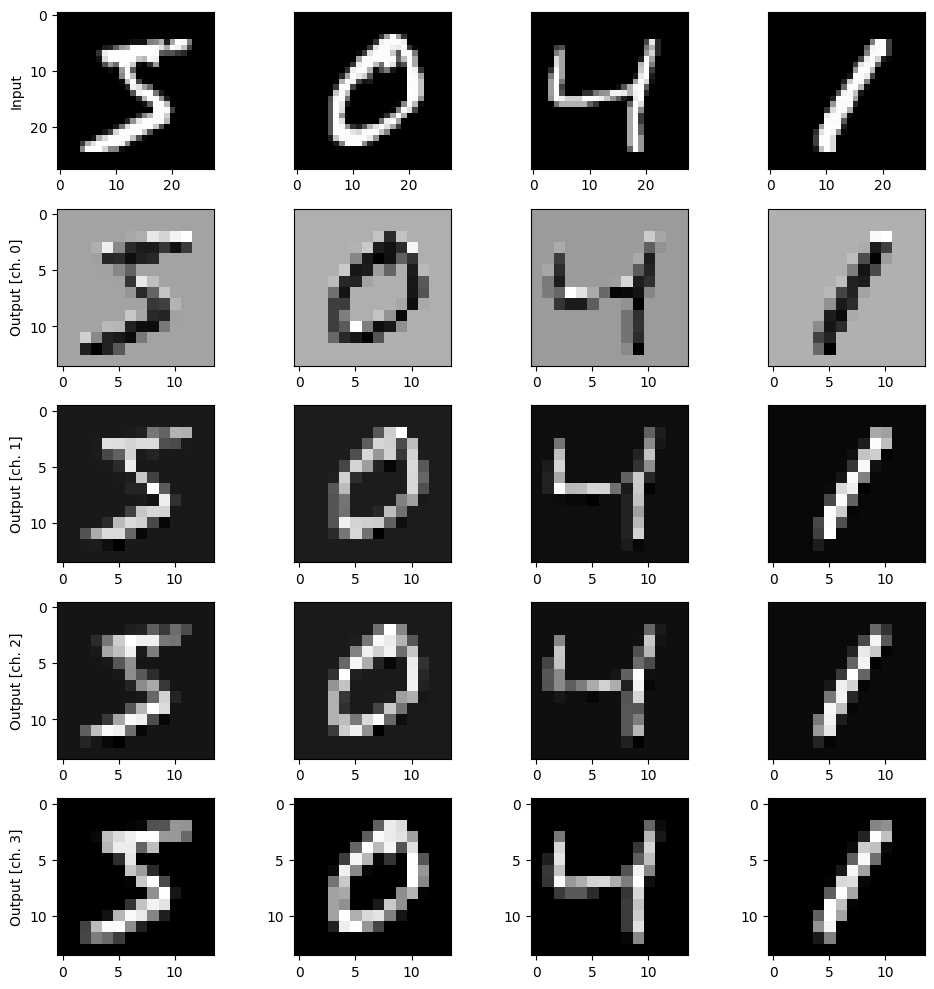

In [5]:
qccnn = Custom_QCCNN(n_qubits, device, n_blocks, n_shots, optimizer, loss, learning_rate, opt_model_path, np_arrays_path)

quantum_train_images, quantum_test_images, params = qccnn.quantum_conv_preprocessing(train_images, test_images)

n_samples = 5
qccnn.plot_quantum_images(train_images, quantum_train_images, n_samples)

5. Upload the quantum_train_images and quantum_test_images if required and create the qccnn object again

In [6]:
upload = False
if upload:
    quantum_train_images= np.load(np_arrays_path + "quantum_train_images.npy")
    quantum_test_images = np.load(np_arrays_path + "quantum_test_images.npy")
    qccnn = Custom_QCCNN(n_qubits, device, n_blocks, n_shots, optimizer, loss, learning_rate, opt_model_path)
    qccnn.params = np.load(np_arrays_path + "quantum_random_params.npy")    

6. For random quantum parameters, train the classical convolutional neural network

In [7]:
batch_size = 8
n_epochs = 50
early_stop_crit = False

history = qccnn.train(
                preprocessing=False,
                train_images=quantum_train_images, 
                train_labels=train_labels, 
                validation_images=quantum_test_images, 
                validation_labels=test_labels, 
                batch_size=batch_size, 
                n_epochs=n_epochs,
                early_stop_crit=early_stop_crit
                )

print("Training of the classical convolutional neural network completed.")


c:\Users\a943763\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Epoch 1/50
13/13 - 4s - 304ms/step - accuracy: 0.0600 - loss: 2.3400 - val_accuracy: 0.3000 - val_loss: 2.2202
Epoch 2/50
13/13 - 0s - 22ms/step - accuracy: 0.2100 - loss: 2.1206 - val_accuracy: 0.3667 - val_loss: 1.8217
Epoch 3/50
13/13 - 0s - 22ms/step - accuracy: 0.5000 - loss: 1.4501 - val_accuracy: 0.5667 - val_loss: 1.1452
Epoch 4/50
13/13 - 0s - 22ms/step - accuracy: 0.7000 - loss: 0.7855 - val_accuracy: 0.6667 - val_loss: 0.8165
Epoch 5/50
13/13 - 0s - 22ms/step - accuracy: 0.8400 - loss: 0.5254 - val_accuracy: 0.7667 - val_loss: 0.6485
Epoch 6/50
13/13 - 0s - 22ms/step - accuracy: 0.9100 - loss: 0.3207 - val_accuracy: 0.7667 - val_loss: 0.8105
Epoch 7/50
13/13 - 0s - 21ms/step - accuracy: 0.9300 - loss: 0.1672 - val_accuracy: 0.8000 - val_loss: 0.8227
Epoch 8/50
13/13 - 0s - 24ms/step - accuracy: 0.9800 - loss: 0.0648 - val_accuracy: 0.7333 - val_loss: 1.6169
Epoch 9/50
13/13 - 0s - 23ms/step - accuracy: 0.9500 - loss: 0.1026 - val_accuracy: 0.8000 - val_loss: 1.2403
Epoch 10/

7. Plot validation loss and validation accuracy

Figure saved at C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/figures_qccnn/qccnn_loss.png


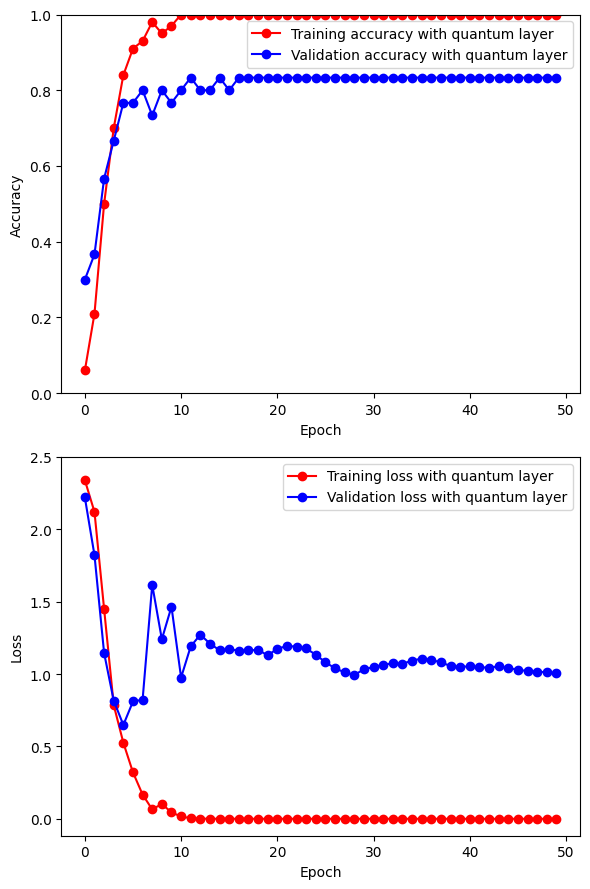

In [8]:
fig_path = np_arrays_path = 'C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/figures_qccnn/'
qccnn.plot_loss(fig_path=fig_path)

8. Train the quantum convolutional network

In [ ]:
method = 'cobyla'
max_iter = 50
n_train_images_q_opt = n_training_images

train_images_q_opt= train_images[:n_train_images_q_opt,:,:,:]
train_labels_q_opt = train_labels[:n_train_images_q_opt]

result, train_accuracies, train_losses = qccnn.optimize_quantum_params(train_images_q_opt, train_labels_q_opt, method, max_iter)

print(f"Quantum training result: {result}")
print(f"\nTraining accuracies: {train_accuracies}")
print(f"\nTraining losses: {train_losses}")

Exception ignored in: <function _xla_gc_callback at 0x000001AF7F980400>
Traceback (most recent call last):
  File "c:\Users\a943763\AppData\Local\Programs\Python\Python311\Lib\site-packages\jax\_src\lib\__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


9. Plot the training accuracy and loss of the quantum ansatz optimization

In [ ]:
qccnn.plot_q_train_loss(train_accuracies=train_accuracies, train_losses=train_losses, fig_path=fig_path)

TypeError: QCCNN.plot_q_train_loss() got multiple values for argument 'train_accuracies'

10. Evaluate the whole model with quantum and classical optimized parameters for test images to analyse performance

In [ ]:
test_loss, test_accuracy = qccnn.predict(
                                preprocessing=True,
                                test_images=test_images,
                                test_labels=test_labels
                                )

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

Test loss: 2.3053436279296875, Test accuracy: 0.10000000149011612
